# Load libraries

In [4]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import csv
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display
import re
from tqdm.notebook import tqdm
import networkx as nx
import os
import shutil
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pickle
import faiss
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.manifold import TSNE
from contextlib import contextmanager
import sys
import codecs
from IPython.display import clear_output
import joblib
import gc
import numpy as np

In [9]:
def load_embeddings(embedding_file):
    return np.load(embedding_file, allow_pickle=True).item()

def get_image_embedding(img_path, model):
        img = Image.open(img_path).resize((224, 224))
        x = np.array(img, dtype=np.float32)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        embedding = model.predict(x)
        return embedding

def find_closest_images_approx(input_embedding, nbrs, database_embeddings, top_k=10):
    # Normalize the input embedding
    input_embedding = input_embedding.flatten()
    input_embedding /= np.linalg.norm(input_embedding)

    # Use NearestNeighbors to find approximate nearest neighbors
    distances, indices = nbrs.kneighbors([input_embedding])

    # Get the paths of the closest images
    closest_images = [list(database_embeddings.keys())[i] for i in indices[0]]

    return closest_images

In [5]:
# load the pkl file
database_embeddings = load_embeddings('database_embeddings_all.npy')

In [6]:
db_matrix = np.vstack(list(database_embeddings.values()))
db_matrix /= np.linalg.norm(db_matrix, axis=1)[:, np.newaxis]

print("Converted to matrix successfully.")

# Use NearestNeighbors to find approximate nearest neighbors
nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(db_matrix)

print("Built NearestNeighbors model successfully.")

# Load the ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

print("Loaded ResNet50 model successfully.")

Converted to matrix successfully.
Built NearestNeighbors model successfully.
Loaded ResNet50 model successfully.


In [13]:
# Get the embedding of the uploaded image
img_path = "E:\\programming\\stamps\\src\\image_detection\\images\\test\\29.jpg"
input_embedding = get_image_embedding(img_path, model)

# Find the closest images
closest_images = find_closest_images_approx(input_embedding, nbrs, database_embeddings, top_k=5)

# Create a list of image files to return
image_files = []
for img_path in closest_images:
    image_files.append(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


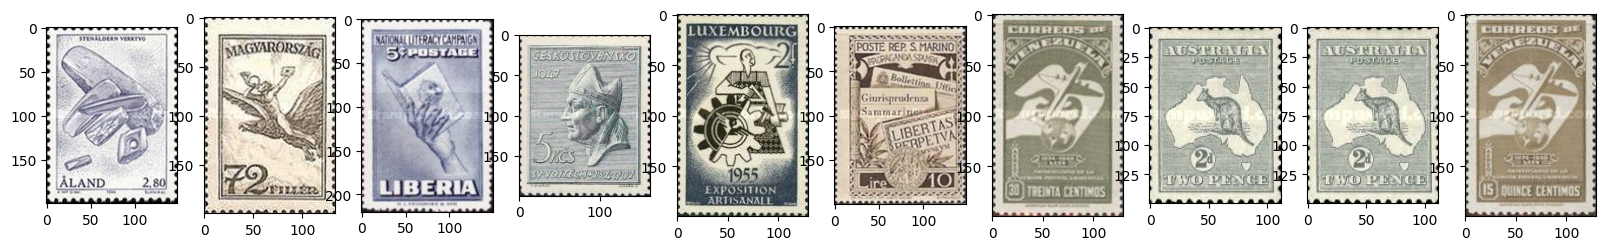

In [16]:
# display the images
fig = plt.figure(figsize=(20, 10))
columns = 10
rows = 1
for i in range(1, columns*rows +1):
    img = Image.open(image_files[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()


# with filtering

In [53]:
def find_closest_images_approx_2(input_embedding, nbrs, database_embeddings, filter_keyword=None, top_k=10):
    # Normalize the input embedding
    input_embedding = input_embedding.flatten()
    input_embedding /= np.linalg.norm(input_embedding)

    # Use NearestNeighbors to find approximate nearest neighbors
    distances, indices = nbrs.kneighbors([input_embedding], n_neighbors=top_k)

    print(len(indices[0]))

    # Filter database embeddings based on the filter keyword if provided
    if filter_keyword:
        filtered_indices = [i for i in indices[0] if filter_keyword in list(database_embeddings.keys())[i]]
        filtered_distances = [distances[0][i] for i in range(len(indices[0])) if filter_keyword in list(database_embeddings.keys())[indices[0][i]]]
    else:
        filtered_indices = indices[0]
        filtered_distances = distances[0]

    # Sort filtered results by distance
    sorted_filtered_indices = [x for _, x in sorted(zip(filtered_distances, filtered_indices))]
    
    # Get the paths of the closest images up to top_k
    closest_images = [list(database_embeddings.keys())[i] for i in sorted_filtered_indices[:top_k]]

    return closest_images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
100
Closest images:
['../crawling/images_all/Aaland\\5620\\CF-s.jpg']


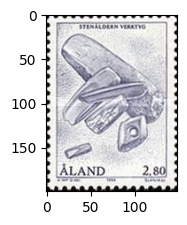

In [54]:
# Get the embedding of the uploaded image
img_path = "E:\\programming\\stamps\\src\\image_detection\\images\\test\\29.jpg"
input_embedding = get_image_embedding(img_path, model)

# Find the closest images with a filter
filter_keyword = "Aaland"
closest_images = find_closest_images_approx_2(input_embedding, nbrs, database_embeddings, filter_keyword=filter_keyword, top_k=100)

print("Closest images:")
print(closest_images)

# Create a list of image files to return
image_files = []
for img_path in closest_images:
    image_files.append(img_path)

# Display the images
fig = plt.figure(figsize=(20, 10))
columns = 10
rows = 1
for i in range(1, min(len(image_files), columns*rows) + 1):
    img = Image.open(image_files[i - 1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()